In [109]:
%load_ext autoreload
%autoreload 2

import datajoint as dj
dj.config["enable_python_native_blobs"] = True
dj.config['nnfabrik.schema_name'] = "nnfabrik_v1_tuning"
schema = dj.schema("nnfabrik_v1_tuning")

import os
from os import listdir
from os.path import isfile, join


import torch
import numpy as np
import pickle 
import time
import matplotlib.pyplot as plt
import seaborn as sns

import nnfabrik
from nnfabrik import main, builder
from nnfabrik.main import *

import nnvision
from nnvision.tables.from_nnfabrik import TrainedModel
from nnvision.tables.legacy.from_mei import TrainedEnsembleModel

import insilico_stimuli
from insilico_stimuli.stimuli import *
from insilico_stimuli.parameters import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
def get_monkey_model(data_key):
    # loading model
    model_hash = 'f8bcd882c48a55dc6cd6d7afb656f1f9'

    model_key = (TrainedModel & dict(model_hash=model_hash)).fetch("KEY", limit=1, order_by="score DESC")
    dataloaders, model = TrainedModel().load_model(model_key, include_dataloader=True)
    model.eval()

    # number of model neurons 
    n_units = model.readout[data_key].outdims

    # image dimensions
    w, h = 41, 41
    
    return model, n_units, w, h, data_key, dataloaders

def get_mouse_model():
    # loading model
    model_hash = 'a09d55344b5793137349b8ca5d17d46d'

    model_key = (TrainedModel & dict(model_hash=model_hash)).fetch("KEY", limit=1, order_by="score DESC")
    dataloaders, model = TrainedModel().load_model(model_key, include_dataloader=True)
    model.eval().cuda()

    # model specifics for optimization
    data_key = '22564-3-12-0'

    # number of model neurons 
    n_units = model.readout[data_key].outdims

    # image dimensions
    w, h = 64, 36
    
    return model, n_units, w, h, data_key

In [111]:
def generate_orientation_gabors(w, h):
    # Finite Set
    canvas_size         = [w, h]
    sizes               = FiniteParameter([20])
    spatial_frequencies = FiniteParameter([1/5])
    contrasts           = FiniteParameter([.5])
    orientations        = FiniteParameter([float(val) for val in np.linspace(0.0, np.pi, 25)])
    phases              = FiniteParameter([np.pi]) 
    grey_levels         = FiniteParameter([0.0])
    eccentricities      = FiniteParameter([0.5])
    locations           = FiniteParameter([[20, 20]])

    gabor_set = GaborSet(canvas_size=canvas_size,
                         locations=locations,
                         sizes=sizes,
                         spatial_frequencies=spatial_frequencies,
                         contrasts=contrasts,
                         orientations=orientations, 
                         phases=phases, 
                         grey_levels=grey_levels,
                         eccentricities=eccentricities)
    
    return gabor_set

## Tunning Stimulus 

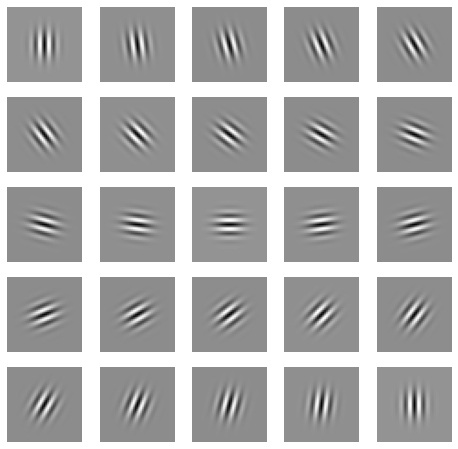

In [112]:
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
axs = axs.flatten()

gabor_set = generate_orientation_gabors(41, 41)

for ax, gabor in zip(axs, gabor_set.images()):
    ax.imshow(gabor, cmap='gray')
    ax.axis('off')

In [162]:
gabor_set.params()

[([[20, 20]], 'location'),
 ([20], 'size'),
 ([0.2], 'spatial_frequency'),
 ([0.5], 'contrast'),
 ([0.0,
   0.1308996938995747,
   0.2617993877991494,
   0.39269908169872414,
   0.5235987755982988,
   0.6544984694978735,
   0.7853981633974483,
   0.916297857297023,
   1.0471975511965976,
   1.1780972450961724,
   1.308996938995747,
   1.4398966328953218,
   1.5707963267948966,
   1.7016960206944711,
   1.832595714594046,
   1.9634954084936205,
   2.0943951023931953,
   2.22529479629277,
   2.356194490192345,
   2.4870941840919194,
   2.617993877991494,
   2.748893571891069,
   2.8797932657906435,
   3.010692959690218,
   3.141592653589793],
  'orientation'),
 ([3.141592653589793], 'phase'),
 ([0.75], 'gamma'),
 ([0.0], 'grey_level')]

In [113]:
def orientation_tuning_curve(model, data_key, gabor_set, cuda=False):
    responses = []
    for gabor in gabor_set.images():
        image = torch.tensor(gabor).expand(1, 1, h, w).float()
        
        if cuda:
            image = image.cuda()

        response = model(image, data_key=data_key).detach()
        
        if cuda:
            response = response.cpu()
        
        response = response.numpy().squeeze()
        responses.append(response)
    
    orientations = gabor_set.params()[4][0]
    
    return orientations, np.array(responses)

## Monkey Orientation Tunning Curve

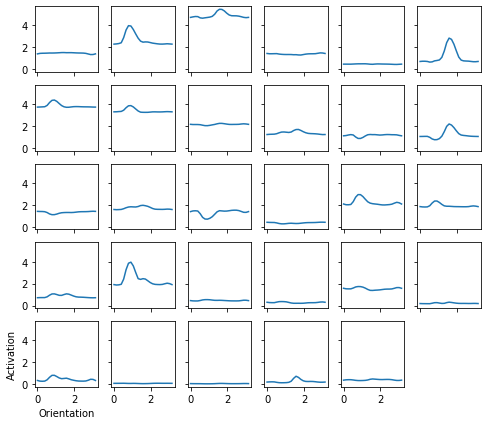

In [142]:
model, n_units, w, h, data_key, dataloaders = get_monkey_model(data_key='3631807112901')
gabor_set = generate_orientation_gabors(w, h)
orientations, responses = orientation_tuning_curve(model, data_key, gabor_set)

n_rows = 5
n_cols = 6

fig, axs = plt.subplots(n_rows, n_cols, figsize=(8, 7), sharex=True, sharey=True)
axs = axs.flatten()

for idx, ax in enumerate(axs[:-1]):
    ax.plot(orientations, responses[:, idx], c='tab:blue')

axs[-1].axis('off')
axs[n_rows * n_cols - n_cols].set_ylabel('Activation')
axs[n_rows * n_cols - n_cols].set_xlabel('Orientation')

plt.savefig('imgs/orientation_tunning_curve_monkey.png', dpi=300)

plt.show()

In [144]:
from nnvision.utility.measures import get_correlations
test_correlation = get_correlations(model, dataloaders["test"], device='cuda', as_dict=True)

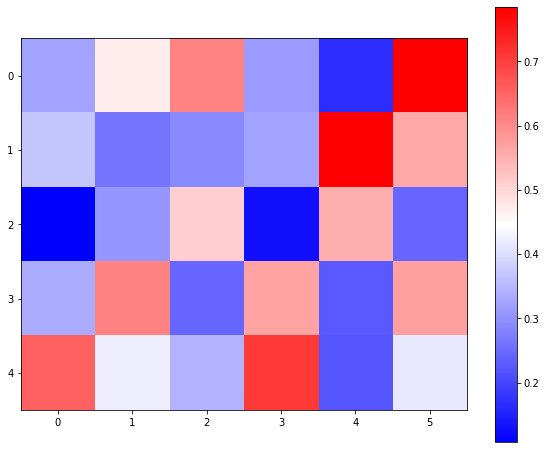

In [159]:
corr = test_correlation[data_key]
corr = np.concatenate((corr, [np.mean(corr)]))
corr = corr.reshape((5, 6))

plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap='bwr')
plt.colorbar()
plt.show()

## Mouse Orientation Tunning Curve

/data/mouse/toliaslab/static/static22564-3-12-preproc0 exists already. Not unpacking /data/mouse/toliaslab/static/static22564-3-12-preproc0.zip


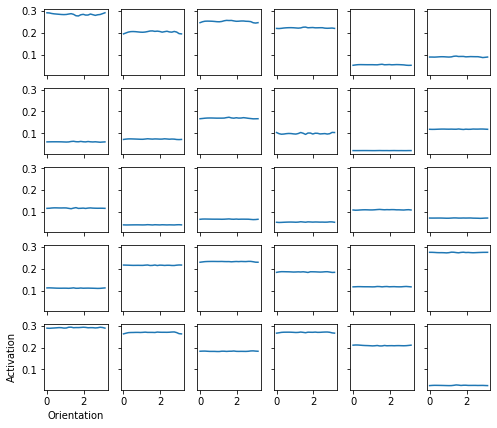

In [118]:
model, n_units, w, h, data_key = get_mouse_model()
gabor_set = generate_orientation_gabors(w, h)
orientations, responses = orientation_tuning_curve(model, data_key, gabor_set, cuda=True)

n_rows = 5
n_cols = 6

fig, axs = plt.subplots(n_rows, n_cols, figsize=(8, 7), sharex=True, sharey=True)
axs = axs.flatten()

for idx, ax in enumerate(axs):
    ax.plot(orientations, responses[:, idx], c='tab:blue')

axs[n_rows * n_cols - n_cols].set_ylabel('Activation')
axs[n_rows * n_cols - n_cols].set_xlabel('Orientation')

plt.savefig('imgs/orientation_tunning_curve_mouse.png', dpi=300)

plt.show()